<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/DiGyt_dev/notebooks/bifurcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bifurcations and chaotic behavior in different neuron models**

asd

In [1]:
!pip install brian2

     |████████████████████████████████| 1.6MB 4.8MB/s 
     |████████████████████████████████| 5.8MB 32.7MB/s 
  Created wheel for brian2: filename=Brian2-2.3.0.2-cp36-cp36m-linux_x86_64.whl size=1283464 sha256=8e859bb7eaab29ed8ef89ab3d57744758d90f6ba7857dbab76a5b4571cbad41c
  Stored in directory: /root/.cache/pip/wheels/86/b5/f6/0c8f9eec58c01e4af55a4c79a5e0385aea01ed03e4ec36c4ac
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [16]:
# import the units and functions that we will use from brian2
from brian2 import (second, ms, volt, mV, nA, pF, nS)
from brian2 import (NeuronGroup, start_scope, defaultclock, run,
                    StateMonitor, SpikeMonitor, linspace, int_)

# import matplotlib and ipywidgets for visualization
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, IntSlider, FloatSlider, FloatRangeSlider

## Examine Bifurcation processes for Neurons

First, we're going to define our model in a brian2-compatible way.
As you might have read in earlier tutorials, we do this by defining strings of differential equations.For this tutorial, we're going to use the "adaptive exponential integrate-and-fire neuron" (AdEx) model (Brette & Gerstner, 2005).It can be described by the following to differential equations, modelling the membrane potential $vm$ and the neuron's adaption current $w$:

$dvm/dt=\frac{g_L*(E_L-vm)+g_L*\Delta_T*exp^{\frac{vm-V_T}{\Delta_T}}+I-w}{C}$

$dw/dt=\frac{a*(vm-E_L)-w}{\tau_w}$

In these functions, $I$ describes the input current, $C$ the membrance capacitance, $g_L$ the leak conductance, $E_L$ the leak reversal potential, $V_T$ the threshold, $\Delta_T$ the slope factor, $a$ the adaption coupling parameter and $\tau_w$ the adaption time constant.

For better visualization, we will record spiking thresholds at $vm > Vcut$ with $Vcut = V_T + 5*\Delta_T$. If this spiking threshold is reached, the membrane potential will be reset to the resting potential $vm = V_r$ and some fixed value $b$ will be added to the post-spike neuron current $w = w + b$.

In [41]:
model = """
dvm/dt=(gL*(EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)+I-w)/C : volt
dw/dt=(a*(vm-EL)-w)/tauw : amp
Vr:volt
"""
threshold = 'vm > Vcut'
reset = "vm = Vr; w += b"

Next, we're going to define the precise values for the parameters used in our model. These are mostly standard values considered for the AdEx model. however, you will be able to play around with them later in this notebook.

In [44]:
C = 281*pF
gL = 30*nS
EL = -70.6*mV
VT = -50.4*mV
DeltaT = 2*mV
tauw = 40*ms
a = 4*nS
b = 0.08*nA
I = .8*nA
Vcut = VT + 5*DeltaT

Now, it's time to do the simulation.
We start a new brian2 scope, define a group of neurons following our model from above, and then run it.

After defining the neuron model, we have to set initial values for our current `w` and our membrane potential `vm`. We also alter the resting voltage `Vr` to which our neurons get set back after spiking between the neurons in our neuron group.
This resting voltage is the parameter which we want to investigate in this example, as we expect complex behavior to emerge when changing this variable.

We then record the spiking behavior and current of these neurons. Since we're interested in the attractor of this system on the long turn, we will run the model for a certain time `init_time` and only start recording the neurons after that initial time.

In [45]:
# define temporal precision of our recordings, and the number of neurons used.
# both parameters will affect the precision of our plots and computational time 
defaultclock.dt = 0.02*ms
N = 200

# start a scope and instatiate a neurongroup of N neurons after the above model
start_scope()
neuron = NeuronGroup(N, model=model, threshold=threshold,
                     reset=reset, method='euler')

# set initial values for (resting) voltage and current across neurons
neuron.vm = EL
neuron.w = a*(neuron.vm - EL)
neuron.Vr = linspace(-48.3*mV, -47.7*mV, N)# bifurcation parameter

# run the models for a certain time without recording the results
init_time = 1*second
run(init_time, report='text')

# run the models again, now recording them with Spike/StateMonitors
states = StateMonitor(neuron, "w", record=True, when='start')
spikes = SpikeMonitor(neuron)
run(1*second, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 2s


Now we can look at the recorded spikes and related currents and plot them.

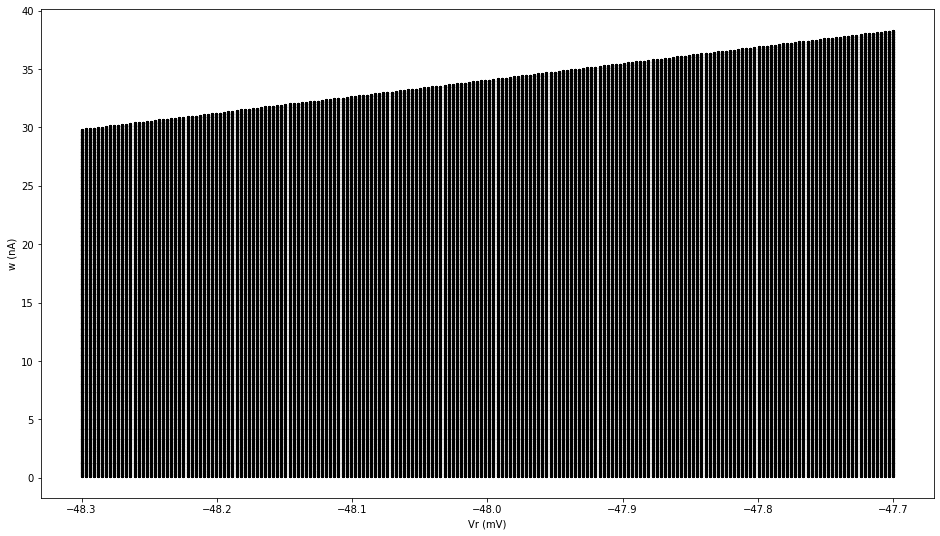

In [46]:
# Get the resting voltage and current for all spikes that were recorded.
Vr_record = neuron.Vr[spikes.i]
w_record = states.w[spikes.i, int_((spikes.t-init_time)/defaultclock.dt)]

# plot them
plt.figure(figsize=(16,9))
plt.scatter(Vr_record / mV, w_record / nA, marker=".", color="k", linewidths=0.1)
plt.xlabel('Vr (mV)')
plt.ylabel('w (nA)')
plt.show()

From this plot, we can see that changing the resting voltage of an AdEx integrate-and-fire neuron can induce chaotic spiking behavior across the range of different neuron currents.

## Try it out yourself...

### AdEx model

In this section, you can try out how chaotic behavior in these neurons develops across certain parameter ranges. To do so, we simply put all the code from the previous section into one function, and make it interactive, using ipywidgets. 

In [19]:
# define the recording time and number of neurons
defaultclock.dt = 0.05*ms
N = 150


# Define the AdEx model
model = """
dvm/dt=(gL*(EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)+I-w)/C : volt
dw/dt=(a*(vm-EL)-w)/tauw : amp
Vr:volt
"""
threshold = 'vm > Vcut'
reset = "vm = Vr; w += b"

# implement the rest of the code as a function
def plot_bifurcation(Vrrange, a, b, I, C, gL, EL, VT, DeltaT, tauw):
  
  C = C*pF
  gL = gL*nS
  EL = EL*mV
  VT = VT*mV
  DeltaT = DeltaT*mV
  tauw = tauw*ms
  a = a*nS
  b = b*nA
  I = I*nA
  Vcut = VT + 5*DeltaT# practical threshold condition

  start_scope()
  neuron = NeuronGroup(N, model=model, threshold=threshold,
                      reset=reset, method='euler')

  neuron.Vr = linspace(Vrrange[0]*mV, Vrrange[1]*mV, N)

  init_time = 1*second
  run(init_time, report='text')# we discard the first spikes

  states = StateMonitor(neuron, "w", record=True, when='start')
  spikes = SpikeMonitor(neuron)
  run(1*second, report='text')

  # Get the values of Vr and w for each spike
  Vr = neuron.Vr[spikes.i]
  w = states.w[spikes.i, int_((spikes.t-init_time)/defaultclock.dt)]

  plt.figure(figsize=(16,9))
  plt.scatter(Vr / mV, w / nA, marker=".", color="k", linewidths=0.1)
  plt.xlabel('Vr (mV)')
  plt.ylabel('w (nA)')
  plt.show()

# plot the function interactively with ipywidgets
layout = {"width": "400px"}
style = {"description_width": "150px"}
Vrrange_slider = FloatRangeSlider(value=[-48.3, -47.7], min=-49., max=-46., step=0.1, description="VrRange (mV): Resting membrane potential/ plotting range", readout_format='.1f', continuous_update=False, layout=layout, style=style)
a_slider = FloatSlider(value=4., min=0., max=10., step=0.25, description="a (nS): Adaption coupling parameter", readout_format='.1f', continuous_update=False, layout=layout, style=style)
b_slider = FloatSlider(value=0.08, min=0.00, max=0.20, step=0.01, description="b (nA): Post-spike current change", continuous_update=False, layout=layout, style=style)
I_slider = FloatSlider(value=0.8, min=0., max=2., step=0.1, description="I (nA): External input current", readout_format = '.1f', continuous_update=False, layout=layout, style=style)
C_slider = IntSlider(value=281, min=270, max=290, step=1, description="C (pF): Membrane capacitance", continuous_update=False, layout=layout, style=style)
gL_slider = IntSlider(value=30, min=20, max=40, step=1, description="gL (nS): Leak conductance", continuous_update=False, layout=layout, style=style)
EL_slider = FloatSlider(value=-70.6, min=-72., max=-70., step=0.1, description="EL (mV): Leak reversal potential", readout_format = '.1f', continuous_update=False, layout=layout, style=style)
VT_slider = FloatSlider(value=-50.4, min=-51., max=-49., step=0.1, description="VT (mV): Spiking threshold", readout_format = '.1f', continuous_update=False, layout=layout, style=style)
DeltaT_slider = FloatSlider(value=2., min=1., max=3., step=0.1, description="DeltaT (mV): Slope factor", readout_format = '.1f', continuous_update=False, layout=layout, style=style)
tauw_slider = IntSlider(value=40, min=30, max=60, step=1, description="tauw (ms): Adaption time constant", continuous_update=False, layout=layout, style=style)

interactive(plot_bifurcation,
            Vrrange = Vrrange_slider, a = a_slider, b = b_slider,
            I = I_slider, C = C_slider, gL = gL_slider, EL = EL_slider,
            VT = VT_slider, DeltaT = DeltaT_slider, tauw = tauw_slider)


interactive(children=(FloatRangeSlider(value=(-48.3, -47.7), continuous_update=False, description='VrRange (mV…

###Izhikevich Model

In [36]:

defaultclock.dt = 0.05*ms

N = 200


model = '''dvm/dt = (0.04/ms/mV)*vm**2+(5/ms)*vm+140*mV/ms-w + I : volt
dw/dt = a*(b*vm-w) : volt/second
d : volt/second'''
threshold = "vm > 35*mV"
reset = "vm = c; w += d"

#adex = Izhikevich()

def plot_bifurcation(a, b, c, d, I):

  I = I * volt/second
  a = a / ms
  b = b / ms
  c = c * mV
  

  start_scope()
  neuron = NeuronGroup(N, model=model, threshold=threshold,
                      reset=reset, method='euler')
  

  neuron.d = linspace(d[0]*volt/second, d[1]*volt/second, N)

  init_time = 1*second
  run(init_time, report='text')# we discard the first spikes

  states = StateMonitor(neuron, "w", record=True, when='start')
  spikes = SpikeMonitor(neuron)
  run(1*second, report='text')

  # Get the values of Vr and w for each spike
  D = neuron.d[spikes.i]
  w = states.w[spikes.i, int_((spikes.t-init_time)/defaultclock.dt)]

  plt.figure(figsize=(16,9))
  plt.scatter(D / volt/second, w / volt/second, marker=".", color="k", linewidths=0.1)
  plt.xlabel('d (volt/second)')
  plt.ylabel('w')
  plt.show()


a_slider = FloatSlider(value = 0.02, min= 0., max = 0.2, step = 0.01, description = 'a (1/ms):', continuous_update=False)
b_slider = FloatSlider(value = 0.2, min= 0., max = 2., step = 0.1, description = 'b (1/ms):', readout_format = '.1f' ,continuous_update=False)
c_slider = IntSlider(value = -55, min= -60, max = -40, step = 1, description = 'c (mV):', readout_format = '.1f', continuous_update=False)
d_slider = FloatRangeSlider(value = [0.5, 1.5], min= 0., max = 3., step = 0.1, description = 'd (volt/second):',continuous_update=False)
I_slider = IntSlider(value = 10, min= 0, max = 20, step = 1, description = 'I (volt/second):',continuous_update=False)

interactive(plot_bifurcation, a = a_slider, b=b_slider, c=c_slider, d=d_slider, I=I_slider)

interactive(children=(FloatSlider(value=0.02, continuous_update=False, description='a (1/ms):', max=0.2, step=…

## References

Brette, R., & Gerstner, W. (2005). Adaptive exponential integrate-and-fire model as an effective description of neuronal activity. *Journal of neurophysiology*, 94(5), 3637-3642.

Izhikevich, E. M. (2003). Simple model of spiking neurons. *IEEE Transactions on neural networks*, 14(6), 1569-1572.

Nobukawa, S., Nishimura, H., Yamanishi, T., & Liu, J. Q. (2015). Chaotic states induced by resetting process in Izhikevich neuron model. *Journal of Artificial Intelligence and Soft Computing Research*, 5(2), 109-119.

Stimberg, M., Brette, R., Goodman, D., Yger, P., & Beroux, W. Brian 2 documentation.

Stimberg, M., Brette, R., & Goodman, D. F. (2019). Brian 2, an intuitive and efficient neural simulator. *Elife*, 8, e47314.


## Try to create neuron models converting the brian stuff to sympy

In [37]:
from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.sympy_parser import standard_transformations, implicit_multiplication_application


class Neuron():

  def __init__(self, differential, threshold, reset):

    self.differential = differential
    self.threshold = threshold
    self.reset = reset


  def _string_to_func(self, equation_str):
    return parse_expr(equation_str, transformations=PARSE_TRANSFORM)

def AdEx():
  """Creates an adaptive exponential integrate-and-fire neuron (Brette-Gerstner model)."""
  differential = """
  dvm/dt=(gL*(EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)+I-w)/C : volt
  dw/dt=(a*(vm-EL)-w)/tauw : amp
  Vr:volt
  """
  threshold = 'vm > Vcut'
  reset = "vm = Vr; w += b"
  return Neuron(differential, threshold, reset)

def Izhikevich():
  differential = '''dvm/dt = (0.04/ms/mV)*vm**2+(5/ms)*vm+140*mV/ms-w + I : volt
  dw/dt = a*(b*vm-w) : volt/second
  I : volt/second
  b : second
  c : volt
  d : volt/second'''
  threshold = "vm > 35mV"
  reset = "vm = c; w += d"
  return Neuron(differential, threshold, reset)
  

In [40]:
from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.sympy_parser import standard_transformations, implicit_multiplication_application
from sympy.utilities.lambdify import lambdify
from sympy.abc import *


PARSE_TRANSFORM = (standard_transformations) # + (implicit_multiplication_application,))

def _string_to_func(equation_str):
  return parse_expr(equation_str, transformations=PARSE_TRANSFORM)

#print(_string_to_func("3*x"))

d = lambdify(x, _string_to_func("3*x"))

a = parse_expr("""(gL * (EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)+I-w)/C""", transformations=PARSE_TRANSFORM)
a

(DeltaT*gL*exp((-VT + vm)/DeltaT) + gL*(EL - vm) - w + I)/C

Starting simulation at t=0. s for a duration of 1. s
0.65537 s (65%) simulated in 10s, estimated 5s remaining.
1. s (100%) simulated in 14s


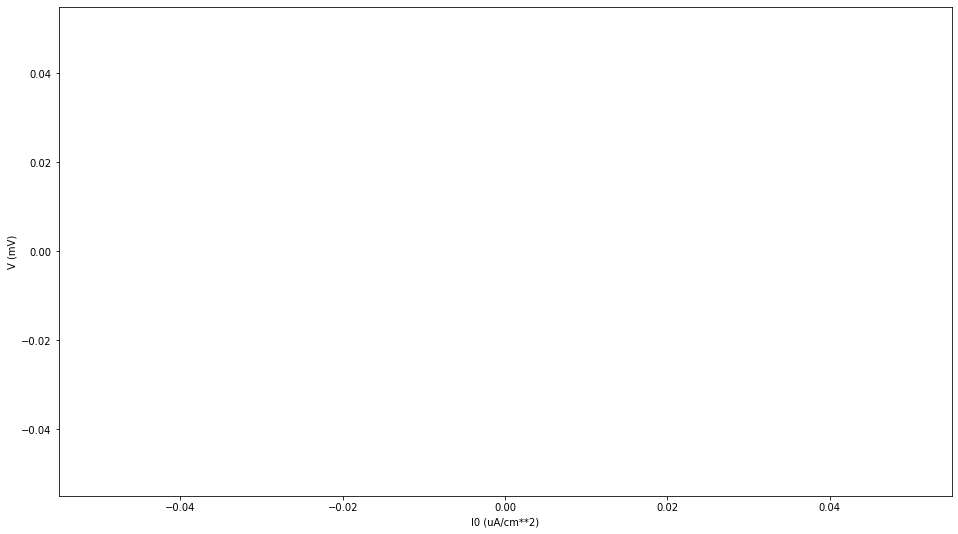

In [ ]:
defaultclock.dt = 0.01*ms
N=900
morpho = Cylinder(length=10*cm, diameter=2*238*um, n=N, type='axon')

El = 10.5995*mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v)+ I : amp/meter**2
I = I0*sin(2*pi*50*Hz * t) : amp/meter**2
I0 : amp/meter**2 # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
gNa : siemens/meter**2
#Cm=1*uF/cm**2 : farad/meter**2
v : volt
'''

  
start_scope()
"""
neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler",
                        refractory="m > 0.1", threshold="m > 0.1",
                        Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
"""
neuron = NeuronGroup(N, model=eqs, threshold="m > 0.5",
                    refractory="m > 0.4", method='exponential_euler')

neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.I0 = linspace(1.732 * uA/cm**2, 1.736 * uA/cm**2, N)
neuron.gNa = gNa0


##init_time = 1*second
#run(init_time, report='text')# we discard the first spikes

states = StateMonitor(neuron, "v", record=True, when='start')
spikes = SpikeMonitor(neuron)
run(1*second, report='text')

# Get the values of Vr and w for each spike
I0 = neuron.I0[spikes.i]
V = states.v[spikes.i, int_((spikes.t-init_time)/defaultclock.dt)]

plt.figure(figsize=(16,9))
plt.scatter(I0 / uA/cm**2, V / mV, marker=".", color="k", linewidths=0.1)
plt.xlabel('I0 (uA/cm**2)')
plt.ylabel('V (mV)')
plt.show()

